# Random Forest, SVC, and Logistic Regression classifiers in fantasy basketball 
This uses a Random Forest Classifier to evaluate feature importances among the 9 head-to-head categories 

In [1]:
import numpy as np
import pandas as pd
import warnings
import codecs
import os

import aut_vinc_bballCrawler as bc

### Grab data from basketball-reference.com

In [2]:
pergame = bc.getSoupFromURL('http://www.basketball-reference.com/leagues/NBA_2016_per_game.html')

In [3]:
pg = pergame.findAll('table')
header = []
for th in pg[0].findAll('th'):
    if not th.getText() in header:
        header.append(th.getText())
rows = pg[0].findAll('tr')[1:]  # all rows but the header
rows = [r for r in rows if len(r.findAll('td')) > 0]
parsed_table = [[col.getText() for col in row.findAll('td')] for row in rows]
ptable = pd.io.parsers.TextParser(parsed_table, names=header[1:30], index_col=0).get_chunk()
# invert the turnover metric
ptable.TOV = 1/ptable.TOV
feature_vec = ['FG%','FT%','3P','TRB','AST','STL','BLK','TOV','PS/G']

In [4]:
mysquad = ['Chris Paul', 'DeMar DeRozan', 'Jeff Teague', 'DeAndre Jordan', 'Kemba Walker', 'Rodney Hood', 'Andrew Bogut', 'Myles Turner', 'Luol Deng', 'Klay Thompson', 'Gary Harris', 'Kyle Korver', 'Giannis Antetokounmpo']
mysqd_table = ptable.loc[mysquad, feature_vec].reset_index()
mysqd_vec = mysqd_table.loc[:, feature_vec].mean(0)
#ptable.replace([ptable.TOV[np.isinf(ptable.TOV)]], [ptable.TOV[~np.isinf(ptable.TOV)].mean()], inplace=True)
ptable.TOV[np.isinf(ptable.TOV)] = ptable.TOV[~np.isinf(ptable.TOV)].mean()
ptable.replace(np.nan, 0, inplace=True)
# ptable

/Users/andric/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [5]:
# Check my squad
mysqd_table

,Player,FG%,FT%,3P,TRB,AST,STL,BLK,TOV,PS/G
0,Chris Paul,0.462,0.896,1.6,4.2,10.0,2.1,0.2,0.384615,19.5
1,DeMar DeRozan,0.446,0.850,0.6,4.5,4.0,1.0,0.3,0.454545,23.5
2,Jeff Teague,0.439,0.837,1.4,2.7,5.9,1.2,0.3,0.357143,15.7
3,DeAndre Jordan,0.703,0.430,0.0,13.8,1.2,0.7,2.3,0.714286,12.7
4,Kemba Walker,0.427,0.847,2.2,4.4,5.2,1.6,0.5,0.476190,20.9
5,Rodney Hood,0.420,0.860,2.0,3.4,2.7,0.9,0.2,0.625000,14.5
6,Andrew Bogut,0.627,0.480,0.0,7.0,2.3,0.5,1.6,0.833333,5.4
7,Myles Turner,0.498,0.727,0.1,5.5,0.7,0.4,1.4,0.909091,10.3
8,Luol Deng,0.455,0.755,1.2,6.0,1.9,1.0,0.4,0.909091,12.3
9,Klay Thompson,0.470,0.873,3.5,3.8,2.1,0.8,0.6,0.588235,22.1


### read in prior results (train and test data)

In [6]:
with codecs.open('autvinc_table.csv', "r",encoding='utf-8', errors='ignore') as fdata:
    bt = pd.read_csv(fdata)

# invert TOV ratio
bt.tov = (1/bt.tov)*(10**3)
bt.describe()

,wk,season,fg.,ft.,X3p,trb,ast,stl,blk,tov,pts
count,370.000000,370.000000,370.000000,370.000000,370.000000,370.000000,370.000000,370.000000,370.000000,370.000000,370.000000
mean,9.756757,1.486486,0.456006,0.771721,44.070270,241.329730,134.994595,42.975676,27.456757,12.678558,614.635135
std,5.351622,0.500494,0.024202,0.048248,13.620303,38.088322,24.327819,8.869237,8.853797,2.422892,87.232141
min,1.000000,1.000000,0.381200,0.611900,14.000000,132.000000,78.000000,19.000000,7.000000,8.264463,363.000000
25%,5.000000,1.000000,0.439250,0.739850,34.000000,213.250000,118.000000,37.000000,22.000000,11.111111,562.000000
50%,10.000000,1.000000,0.455900,0.776150,43.000000,239.000000,133.000000,43.000000,27.000000,12.345679,612.500000
75%,14.000000,2.000000,0.474700,0.805500,52.750000,269.000000,151.000000,48.000000,33.000000,13.888889,666.750000
max,19.000000,2.000000,0.520700,0.882000,87.000000,355.000000,205.000000,78.000000,64.000000,23.809524,913.000000


In [7]:
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

In [585]:
X = np.array(bt.iloc[:,3:])
ss = StandardScaler()
ssX = ss.fit_transform(X)
labels = []
for i in range(0, X.shape[0], 2):
    if len(np.where((X[i, :] - X[i+1,:]) > 0)[0]) > 4:
        labels.append('win')
        labels.append('loss')
    else:
        labels.append('loss')
        labels.append('win')

le = LabelEncoder()
y = le.fit_transform(np.array(labels))
X_train, X_test, y_train, y_test = train_test_split(ssX, y,
                                                    test_size=0.2, random_state=0)

## Random Forest classifier

In [586]:
from sklearn.ensemble import RandomForestClassifier
feat_labels = feature_vec
forest = RandomForestClassifier(n_estimators=10000, random_state=0, n_jobs=-1)
forest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10000, n_jobs=-1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [587]:
importances = forest.feature_importances_
indices = np.argsort(importances)[::-1]
for f in range(X_train.shape[1]):
    print("%3d) %-*s %f" % (f+1, 30, feat_labels[indices[f]], importances[indices[f]]))

  1) PS/G                           0.206430
  2) BLK                            0.126906
  3) AST                            0.113935
  4) 3P                             0.113297
  5) TRB                            0.100334
  6) FG%                            0.090875
  7) TOV                            0.086079
  8) FT%                            0.083384
  9) STL                            0.078760


In [552]:
from sklearn.metrics import accuracy_score

In [588]:
y_train_pred = forest.predict(X_train)
y_test_pred = forest.predict(X_test)
forest_train = accuracy_score(y_train, y_train_pred)
forest_test = accuracy_score(y_test, y_test_pred)
print('Train/test accuracies: %.3f/%.3f' % (forest_train, forest_test))

Train/test accuracies: 1.000/0.622


### 0.649 is not so hot. 

## Now look at Bagging

In [589]:
from sklearn.ensemble import BaggingClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(criterion='entropy', max_depth=None)
bag = BaggingClassifier(base_estimator=tree,
                        max_samples=1.0, max_features=1.0,
                        bootstrap=True, bootstrap_features=False,
                        n_jobs=-1, random_state=0)

In [590]:
bag = bag.fit(X_train, y_train)
y_train_pred = bag.predict(X_train)
y_test_pred = bag.predict(X_test)
bag_train = accuracy_score(y_train, y_train_pred)
bag_test = accuracy_score(y_test, y_test_pred)
print('Bagging train/test accuracies: %.3f/%.3f' % (bag_train, bag_test))

Bagging train/test accuracies: 0.976/0.527


## SVC and tune hyperparameters

In [219]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.grid_search import GridSearchCV
from sklearn.svm import SVC

In [591]:
pipe_svc = Pipeline([('sc1', StandardScaler()),
                    ('clf', SVC(random_state=0))])
param_range = [10**-4, 10**-3, 10**-2, 10**-1, 1.0, 10.0, 10**2, 10**3]
param_grid = [{'clf__C': param_range,
               'clf__kernel': ['linear']},
              {'clf__C': param_range,
               'clf__gamma': param_range,
               'clf__kernel': ['rbf']}]
gs = GridSearchCV(estimator=pipe_svc,
                 param_grid=param_grid,
                 scoring='accuracy',
                 cv=10,
                 n_jobs=-1)
gs = gs.fit(X_train, y_train)
print(gs.best_params_)
print('Best score: %.3f' % gs.best_score_)


{'clf__gamma': 0.0001, 'clf__kernel': 'rbf', 'clf__C': 1000}
Best score: 0.736


## Logistic Regression

In [751]:
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.cross_validation import cross_val_score

labels = []
for i in range(0, X.shape[0], 2):
    if len(np.where((X[i, :] - X[i+1,:]) > 0)[0]) > 4:
        labels.append('win')
        labels.append('loss')
    else:
        labels.append('loss')
        labels.append('win')

le = LabelEncoder()
y = le.fit_transform(np.array(labels))
# X_train, X_test, y_train, y_test = train_test_split(ssX, y,
#                                                    test_size=0.2)

pipe_lr = Pipeline([('sc1', StandardScaler()),
                   ('pca', PCA()),
                   ('clf', LogisticRegression(random_state=0))])
pipe_lr.fit(X_train, y_train)
print('Test accuracy: %.3f' % pipe_lr.score(X_test, y_test))
scores = cross_val_score(estimator=pipe_lr, X=X_train, y=y_train, cv=10, n_jobs=1)
print('CV accuracy %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

Test accuracy: 0.622
CV accuracy 0.720 +/- 0.054


## look at the learning curve

(0.5, 1.0)

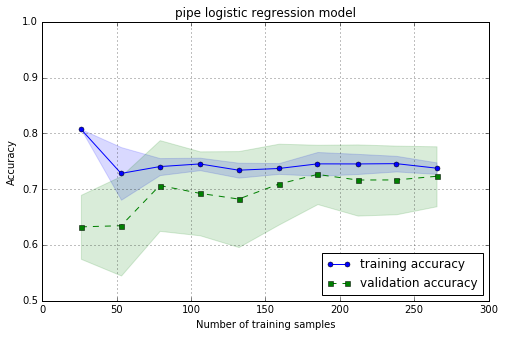

In [594]:
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.learning_curve import learning_curve

train_sizes, train_scores, test_scores = learning_curve(estimator=pipe_lr,
                                                       X=X_train,
                                                       y=y_train,
                                                       train_sizes=np.linspace(0.1, 1.0, 10),
                                                       cv=10,
                                                       n_jobs=1)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.figure(figsize=(8, 5))
plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='training accuracy')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std,
                alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', markersize=5,
         label='validation accuracy')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')
plt.grid()
plt.title('pipe logistic regression model')
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.5, 1.0])

In [595]:
pipe_lr.predict(ss_ptable[pl_ind, :].mean(0)[np.newaxis, :])

array([1])

## SVC

Use parameters here found via the above grid search

In [643]:
ss = StandardScaler()
#X = np.array(bt.iloc[:,3:])
#ssX = ss.fit_transform(X)
labels = []
for i in range(0, X.shape[0], 2):
    if len(np.where((X[i, :] - X[i+1,:]) > 0)[0]) > 5:
        labels.append('win')
        labels.append('loss')
    else:
        labels.append('loss')
        labels.append('win')

le = LabelEncoder()
y = le.fit_transform(np.array(labels))
#X_train, X_test, y_train, y_test = train_test_split(ssX, y,
#                                                    test_size=0.1)

ss_ptable = ss.fit_transform(ptable.loc[:, feature_vec])

svc = SVC(C=1000, gamma=0.0001, kernel='rbf', probability=True)
svc.fit(X_train, y_train)
print(feature_vec)
print(np.round(ss_ptable[pl_ind, :].mean(0)[np.newaxis, :].ravel(), 3))
print('SVC Prediction: %d' % svc.predict(ss_ptable[pl_ind, :].mean(0)[np.newaxis, :]))
scores = cross_val_score(estimator=svc, X=X_train, y=y_train, cv=10, n_jobs=-1)
print('CV for svc accuracy %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

['FG%', 'FT%', '3P', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PS/G']
[ 0.723 -0.021  0.199  1.275 -0.106  0.401  0.858 -0.458  0.692]
SVC Prediction: 1
CV for svc accuracy 0.733 +/- 0.072


In [362]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [758]:
mysquad = ['Chris Paul', 'Markieff Morris', 'Otto Porter', 'Rudy Gobert',
           'Kemba Walker', 'Kevin Durant', 'Myles Turner', 'Monta Ellis',
           'Emmanuel Mudiay', 'Gary Harris', 'Andrew Bogut', 'Giannis Antetokounmpo']
# mysquad = ['Luol Deng', 'Timofey Mozgov', 'Rodney Hood', 'Dwight Howard']

pl_ind = []
for pp in mysquad:
    pl_ind.append(np.where(ptable.index==pp)[0][0])

print('SVC Prediction: %d' % svc.predict(ss_ptable[pl_ind, :].mean(0)[np.newaxis, :]))
prob_loss, prob_win = svc.predict_proba(ss_ptable[pl_ind, :].mean(0)[np.newaxis, :]).ravel()
print('SVC probability Loss: %.3f Win: %.3f' % (prob_loss, prob_win))
# scores = cross_val_score(estimator=svc, X=X_train, y=y_train, cv=10, n_jobs=-1)
# print('CV for svc accuracy %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

#print('Forest prediction: %d ' % forest.predict(ss_ptable[pl_ind, :].mean(0)[np.newaxis, :]))
#scores = cross_val_score(estimator=forest, X=X_train, y=y_train, cv=10, n_jobs=-1)
#print('Cross val for Forest accuracy %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))


SVC Prediction: 1
SVC probability Loss: 0.178 Win: 0.822


In [722]:
np.where(ptable.index=='Michael Carter-Williams')[0]

array([86])

In [697]:
print(feature_vec)
print(np.round(svc.support_vectors_[101:].mean(0) - svc.support_vectors_[:101].mean(0), 3))

['FG%', 'FT%', '3P', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PS/G']
[ 0.011  0.023  0.057  0.02   0.037  0.002  0.048 -0.037  0.077]


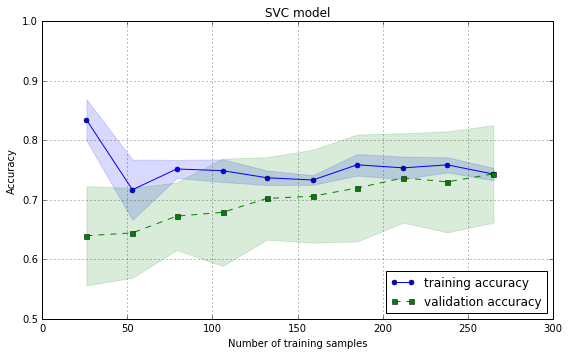

In [634]:
from sklearn.learning_curve import learning_curve

train_sizes, train_scores, test_scores = learning_curve(estimator=svc,
                                                       X=X_train,
                                                       y=y_train,
                                                       train_sizes=np.linspace(0.1, 1.0, 10),
                                                       cv=10,
                                                       n_jobs=1)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.figure(figsize=(8, 5))
plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='training accuracy')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std,
                alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', markersize=5,
         label='validation accuracy')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')
plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.title('SVC model')
plt.legend(loc='lower right')
plt.ylim([0.5, 1.0])
plt.tight_layout()
plt.show()

In [759]:
lr_pred_loss, lr_pred_win = pipe_lr.predict_proba(ss_ptable[pl_ind, :].mean(0)[np.newaxis, :]).ravel()
print('pipe logistic regr probability Loss: %.3f Win: %.3f' % (lr_pred_loss, lr_pred_win))

pipe logistic regr probability Loss: 0.122 Win: 0.878


In [761]:
clf_labels = ['Logistic Regr Pipe', 'SVC']
print('10-fold cross validation: \n')
for clf, label in zip([pipe_lr, svc], clf_labels):
    scores = cross_val_score(estimator=clf, X=X_train, y=y_train,
                             cv=10, scoring='roc_auc')
    print('ROC AUC: %0.2f (+/- %0.2f) [%s]' % (scores.mean(), scores.std(), label))

10-fold cross validation: 

ROC AUC: 0.77 (+/- 0.09) [Logistic Regr Pipe]
ROC AUC: 0.76 (+/- 0.09) [SVC]
